In [1]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import random
from sklearn.cluster import KMeans

### Анализ данных

In [2]:
segment_directory = "data/segmentation.csv"

segment = pd.read_csv(segment_directory, header=0 )

In [3]:
segment.head()

,CustomerId,Monetary,Recency,Frequency,factor_1,factor_2,factor_3,factor_4
0,8b4f8c66-7589-4734-8ada-2d42f60540ab,100.40,2019-06-04,6,0.35,0.08,0.609740,0.949383
1,2151b2a2-8867-4986-9e00-449c2b4f89e9,170.00,2019-05-25,4,0.66,0.16,0.942272,0.479846
2,3111db79-6721-4ec0-82b1-30b810649c5e,70.75,2019-05-25,6,0.92,0.20,0.323030,0.007076
3,9cb76426-cc5d-4fa3-88bc-b92314b9f4e8,75.00,2019-03-20,10,0.35,0.78,0.876833,0.088974
4,5d86caeb-2d53-44a7-b379-7f15f06ca821,94.51,2019-04-10,5,0.51,0.44,0.912099,0.206194


In [4]:
segment.describe()

,Monetary,Frequency,factor_1,factor_2,factor_3,factor_4
count,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000
mean,129.972264,3.950687,0.500008,0.497864,0.495451,0.498427
std,179.809263,5.189864,0.290144,0.291103,0.289034,0.288478
min,0.000000,1.000000,0.000000,0.000000,0.000037,0.000033
25%,20.910000,1.000000,0.250000,0.240000,0.242545,0.248739
50%,59.275000,2.000000,0.500000,0.500000,0.496410,0.498833
75%,170.000000,5.000000,0.750000,0.750000,0.744476,0.747424
max,3040.000000,111.000000,1.000000,1.000000,0.999996,0.999943


In [5]:
segment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CustomerId  16000 non-null  object 
 1   Monetary    16000 non-null  float64
 2   Recency     16000 non-null  object 
 3   Frequency   16000 non-null  int64  
 4   factor_1    16000 non-null  float64
 5   factor_2    16000 non-null  float64
 6   factor_3    16000 non-null  float64
 7   factor_4    16000 non-null  float64
dtypes: float64(5), int64(1), object(2)
memory usage: 1000.1+ KB


Для анализа хорошо, что нет пропущенных значений. Отмечу, что характеристика *Recency* имеет тип *object*, что делает затруднительным использование её в дальнейшем. Переведем ее в тип *datatime* и создадим новую переменную *Recent_day*, которая будет показывать сколько дней назад клиент совершил последний платеж.

In [6]:
segment.Recency = pd.to_datetime(segment.Recency)
segment['Recency_day'] = ((segment.Recency.max() - segment.Recency).dt.days) #сколько дней назад клиент сделал последний платеж?

In [7]:
segment.head()

,CustomerId,Monetary,Recency,Frequency,factor_1,factor_2,factor_3,factor_4,Recency_day
0,8b4f8c66-7589-4734-8ada-2d42f60540ab,100.40,2019-06-04,6,0.35,0.08,0.609740,0.949383,12
1,2151b2a2-8867-4986-9e00-449c2b4f89e9,170.00,2019-05-25,4,0.66,0.16,0.942272,0.479846,22
2,3111db79-6721-4ec0-82b1-30b810649c5e,70.75,2019-05-25,6,0.92,0.20,0.323030,0.007076,22
3,9cb76426-cc5d-4fa3-88bc-b92314b9f4e8,75.00,2019-03-20,10,0.35,0.78,0.876833,0.088974,88
4,5d86caeb-2d53-44a7-b379-7f15f06ca821,94.51,2019-04-10,5,0.51,0.44,0.912099,0.206194,67


C:\Users\21363\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


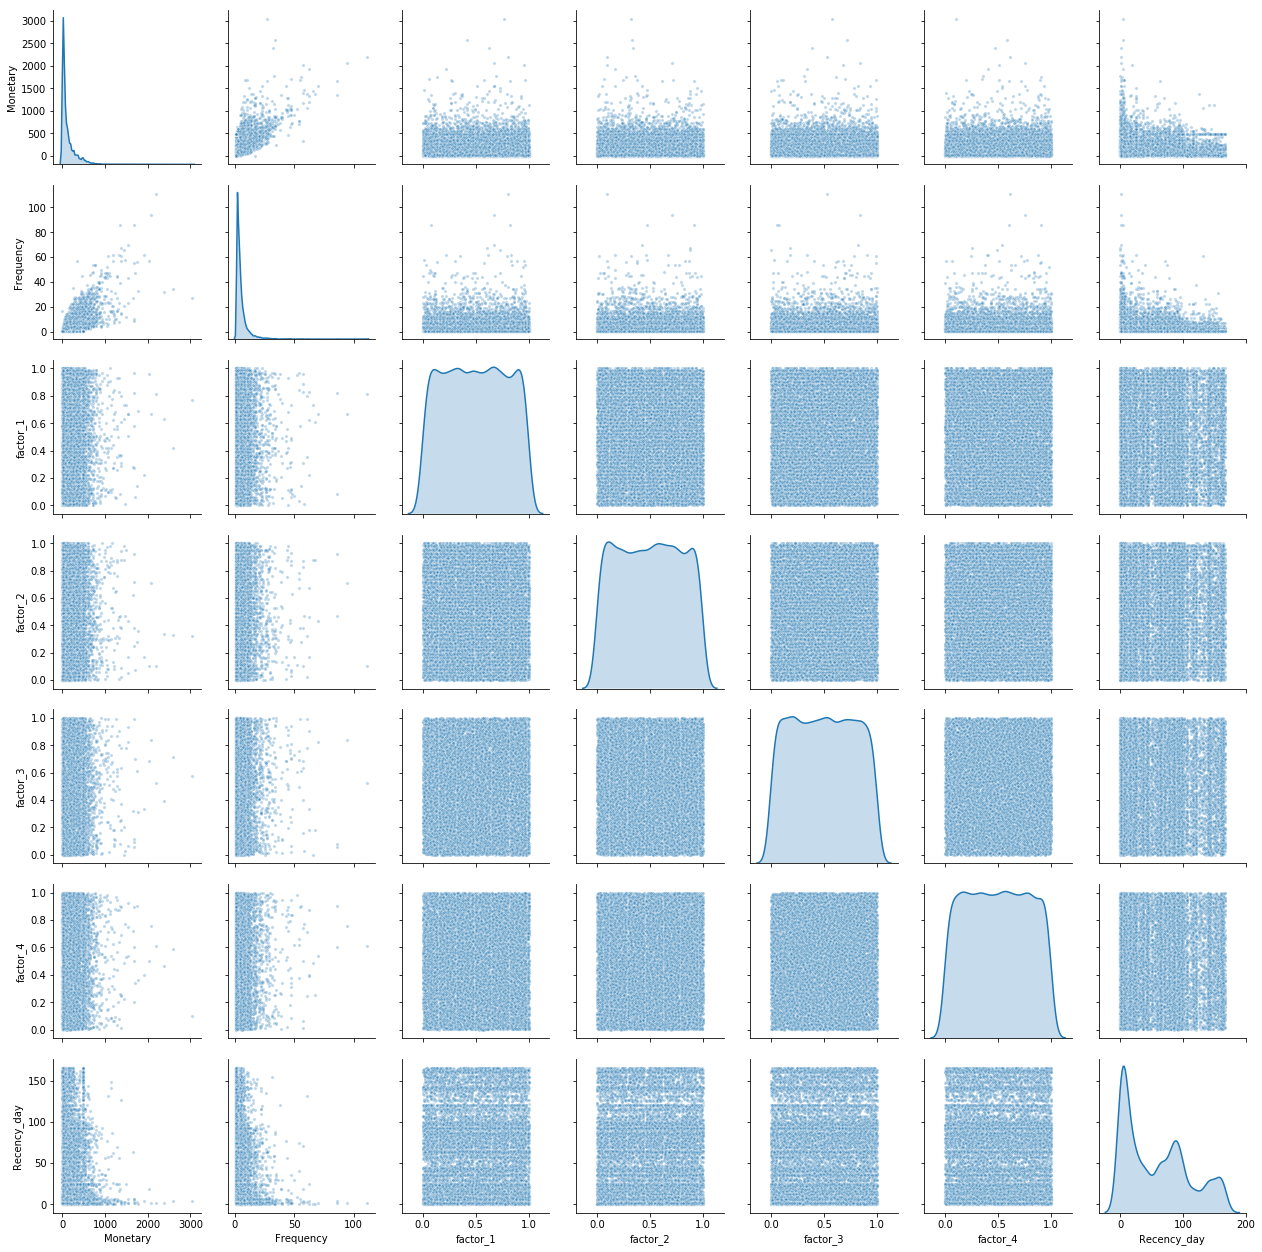

In [8]:
sns.pairplot(segment, diag_kind="kde",
                 plot_kws=dict(s=10, alpha=0.3),
                 diag_kws=dict(shade=True)
)

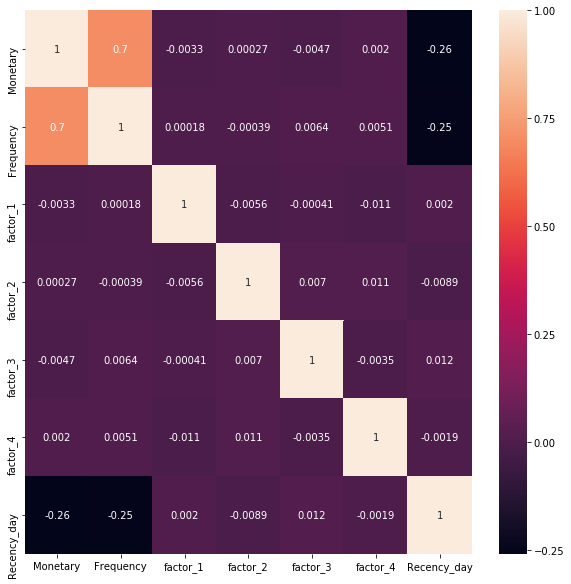

In [9]:
plt.figure(figsize = (10,10))
corrMatrix = segment.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

На первый взгляд кажется, что хактеристики *factor_N* не несут никакой полезной информации. Обратим на них более пристальное внимание далее.  
Также стоит отметить корреляцию между *Monetary* и *Frequency*. *Recent_day* имеет волнообразный характер. Пики могут быть вызваны различными акциями или маркетинговыми кампаниями.

### PCA

Снизим размерность нашего датасета с помощью метода главных компонент до трех.

In [10]:
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(segment._get_numeric_data())
print(pca.explained_variance_ratio_)

[9.29992677e-01 6.96144482e-02 3.83280902e-04]


In [11]:
PCA_components = pd.DataFrame(principalComponents)
PCA_components.head()

,0,1,2
0,-25.706549,-49.098296,2.287892
1,42.823957,-33.580150,-1.015892
2,-56.051114,-41.489579,2.948598
3,-56.977265,24.614992,7.352487
4,-35.966355,5.263480,1.811929


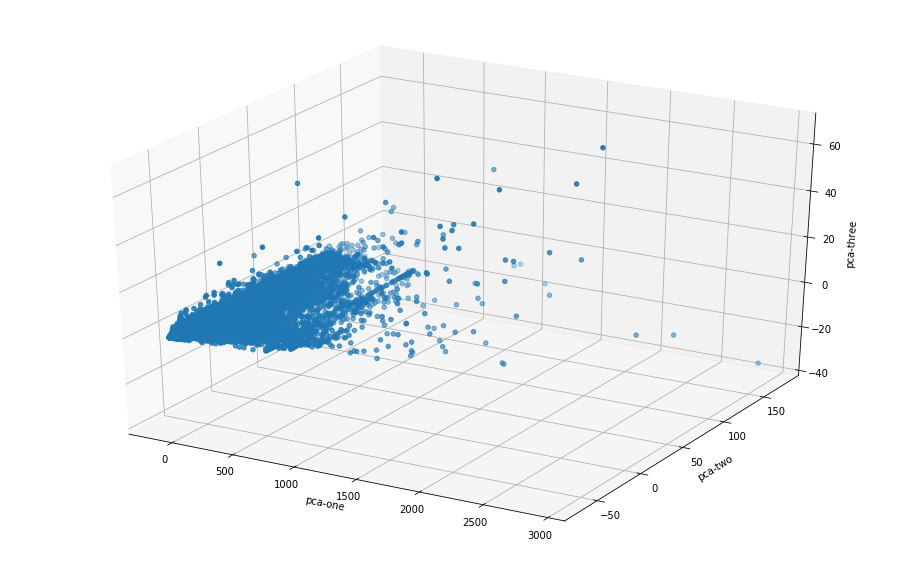

In [12]:
rndperm = list(range(1,1000))

ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=principalComponents[:,0], 
    ys=principalComponents[:,1] , 
    zs=principalComponents[:,2], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

### Сегментация клиентов

Воспользуемся методом KMeans. Для определения оптимального количества кластеров используем *Elbow method*

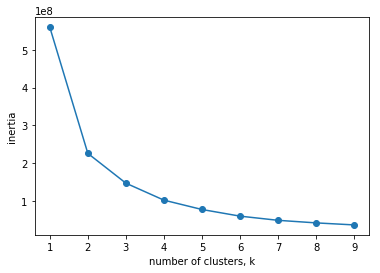

In [13]:
ks = range(1, 10)
inertias = []
for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(PCA_components)
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

Наиболее оптимальным является 2, 3 или 4 кластера. В условиях задачи предлагается разбить данные на 4 кластера, так и поступим.

In [14]:
kmeans = KMeans(n_clusters=4, random_state=42).fit(PCA_components)

In [15]:
ar = np.unique(kmeans.labels_, return_counts=True)
for n, v in zip(ar[0], ar[1]):
    print("Кластер {} - {} значений".format(n, v))

Кластер 0 - 3234 значений
Кластер 1 - 11467 значений
Кластер 2 - 91 значений
Кластер 3 - 1208 значений


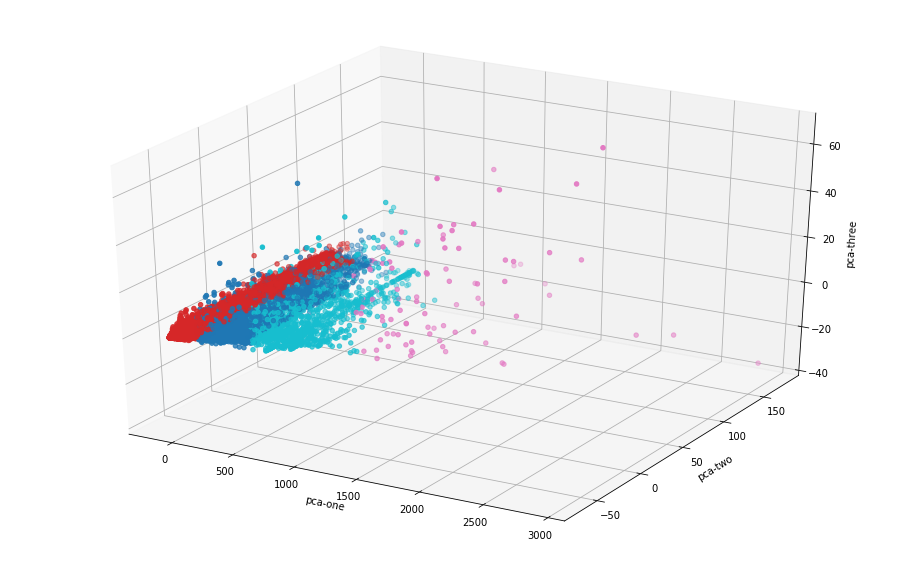

In [16]:
rndperm = list(range(1,1000))

ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=principalComponents[:,0], 
    ys=principalComponents[:,1], 
    zs=principalComponents[:,2], 
    c=kmeans.labels_,
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

Произошло сегментирование на 4 кластера. Посмотрим как они соотносятся с данными

In [17]:
df = pd.concat([segment, pd.Series(kmeans.labels_, name='label')], axis=1)

C:\Users\21363\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\21363\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\21363\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


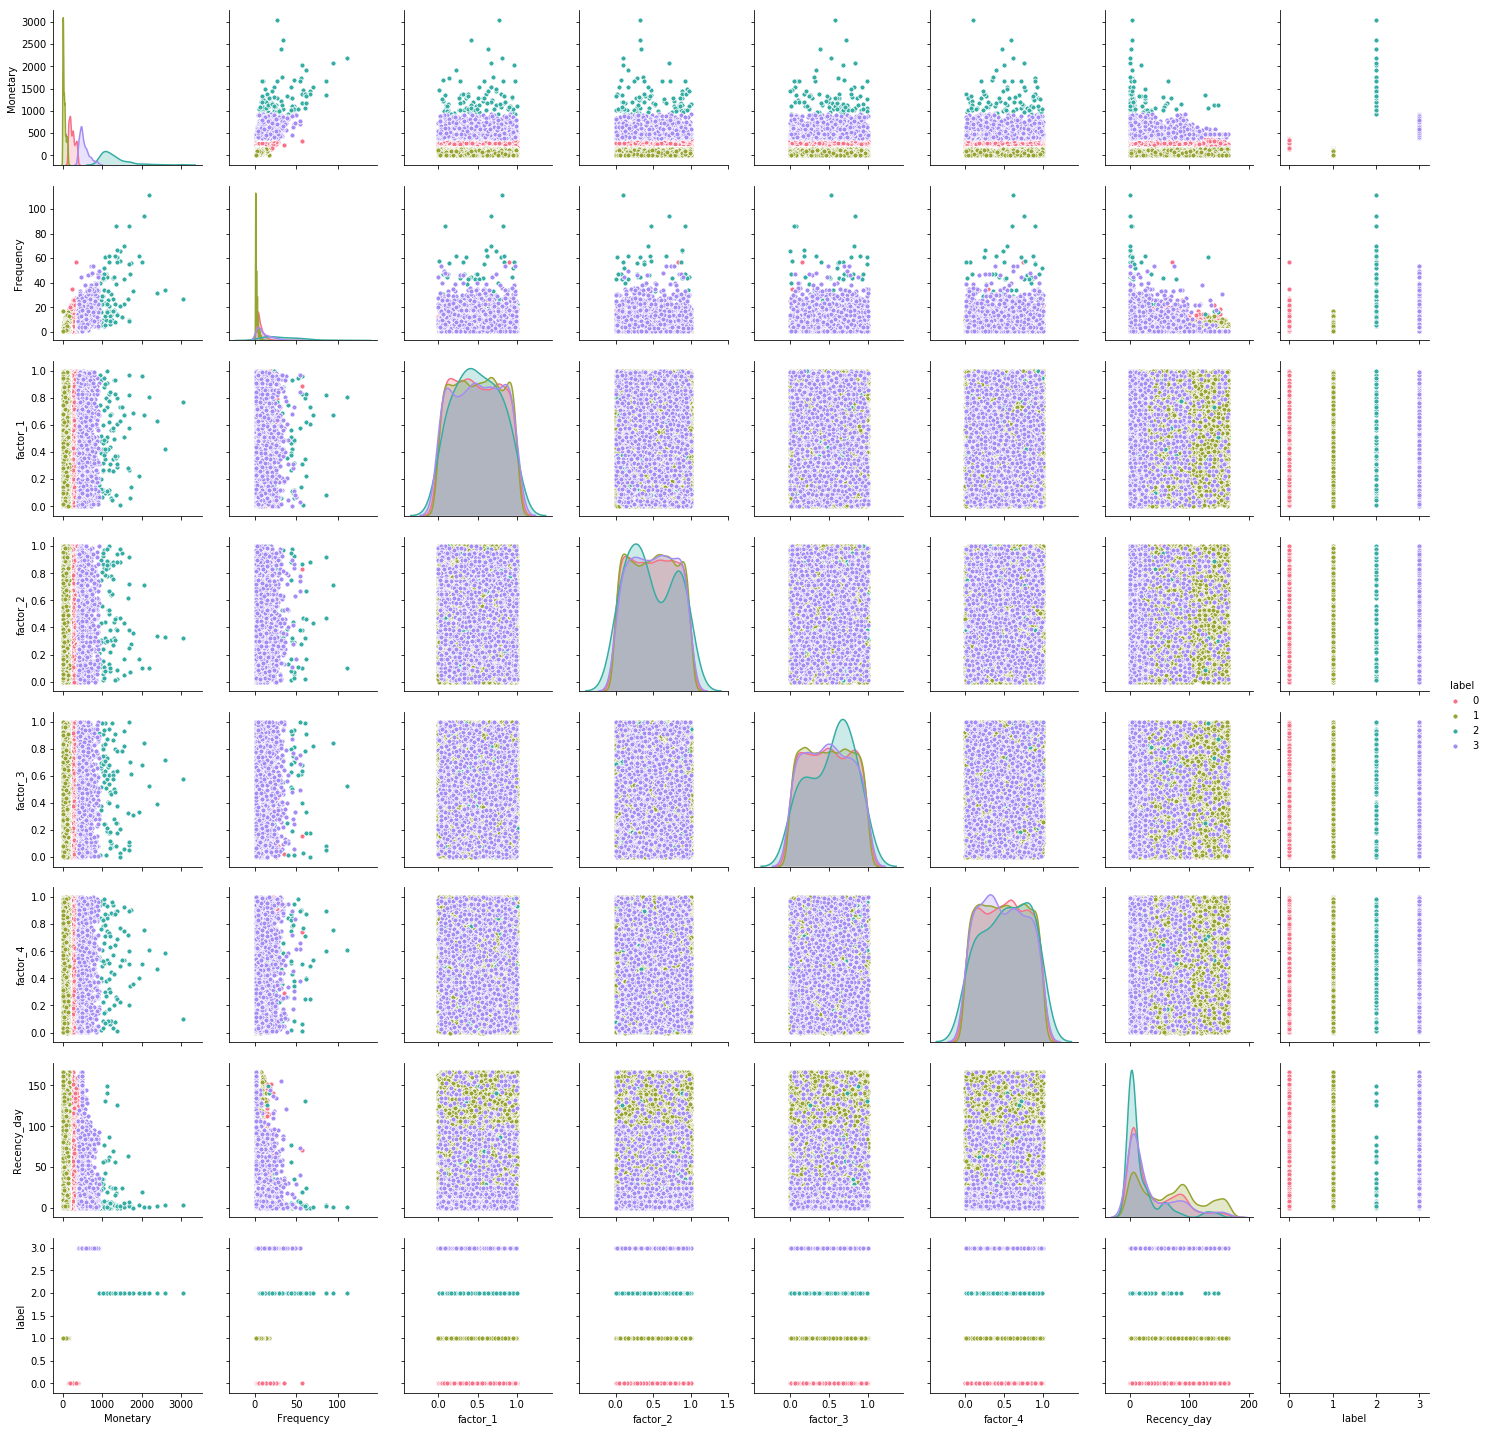

In [18]:
sns.pairplot(df, hue='label', palette="husl",
             diag_kind="kde",
                 plot_kws=dict(s=25),
                 diag_kws=dict(shade=True)
)

### Средние значения каждого кластера

In [19]:
df.groupby(['label']).mean()

,Monetary,Frequency,factor_1,factor_2,factor_3,factor_4,Recency_day
label,,,,,,,
0,242.045043,6.448052,0.493813,0.494981,0.496664,0.501466,37.256339
1,45.462285,2.293712,0.501853,0.498196,0.495448,0.498369,67.782419
2,1305.478681,33.659341,0.497473,0.481099,0.530097,0.528141,19.296703
3,543.599313,10.755795,0.499272,0.503692,0.489613,0.488604,35.280629


In [20]:
df.groupby(['label']).median()

,Monetary,Frequency,factor_1,factor_2,factor_3,factor_4,Recency_day
label,,,,,,,
0,230.00,5,0.485,0.50,0.496583,0.502937,17
1,32.39,2,0.500,0.50,0.496586,0.498471,65
2,1195.00,27,0.490,0.43,0.603210,0.533806,5
3,500.00,8,0.500,0.51,0.487974,0.469759,15


### Выводы

По полученным выше результатам можно сделать следующие выводы:
1. *factor_2* и *factor_3* не несут информации. Их распределение на размеченных данных нормальное, у каждого кластера их значения доволно близки.
2. По медиане и средним значениям каждого кластера можно сделать вывод, что разделение произошло на следующие категории:

**Кластер 2**: Клиенты с самыми большими значениями *Monetary*, *Frequency* и последний раз они что-то покупали не так давно (*Recent_day*). Это довольно лояльные клиенты, которых, скорее всего, все устраивает. Они готовы и дальше продолжать пользоваться услугами. **Клиенты из этого кластера приносят большую часть денег.**  
  
**Кластер 3**: Я бы отнес этих клиентов к классу **среднего пользователя**. Он занимают второе место по значениям *Monetary*, *Frequency*, а также их средняя покупка дороже, чем у клиентов кластер 0 и 1. Однако они пользуются услугами не так часто. Возможно, для большего привлечения их стоит проводить небольшие дополнительные акции или маркетинговые кампании. 

**Кластер 0**: К этому кластеру относятся клиенты, которые пока **не готовы часто и много пользоваться услугами**. Они довольно близки к клиентам из кластера 3. Возможно, как и клиентов из кластера 3, их привлекают акции и кампании, но на них они покупают более дешевые продукты. Думаю, что здесь тоже помогут небольшие дополнительные акции для их привлечения.

**Кластер 1**: Сюда относятся клиенты, которые **воспользовались нашим продуктом 1-3 раза, и он им скорее всего не понравился**. Возможно, эти клиенты пришли на одной из акции, использовали сервис, получили результат, который их не удовлетворил и перестали пользоваться сервисом. Скорее всего, стоит проанализировать действия этих пользователей. Такой анализ позволит в дальнейшем задерживать похожих пользователей в продукте дольше. Для повторного привлечения необходимо использовать довольно сильные маркетинговые инструменты. Окупаемость этих инструментов нужно оценивать дополнительно, так как средний чек таких клиентов самый низкий.